Stock Calculator Automation
----------------
This automation allows you to create a simple webpage with an input form that allows to select a date and when submitted, you see a higest rising stock from a selected set of stocks. 


Needed imports

In [ ]:
from bspump.jupyter import *
from bspump.http.web.server import *
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import io
from datetime import date
import base64

Global variables because we are simplifying the code

In [ ]:
STOCKS = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META", "JPM", "NFLX", "AMD"]

HEADERS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
        }

Functions for fetching and processing data from Yahoo finance API.

In [17]:
def fetch_yahoo_price(ticker, start_date, end_date):
    start_ts = int(time.mktime(start_date.timetuple()))
    end_ts = int(time.mktime(end_date.timetuple()))
    url = f"https://query1.finance.yahoo.com/v8/finance/chart/{ticker}"
    params = {
        "period1": start_ts,
        "period2": end_ts,
        "interval": "1d"
    }

    try:
        resp = requests.get(url, params=params, headers=HEADERS)
        data = resp.json()

        result = data["chart"]["result"][0]
        timestamps = result["timestamp"]
        closes = result["indicators"]["quote"][0]["close"]

        dates = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d') for ts in timestamps]
        return pd.Series(closes, index=dates)
    except Exception as e:
        print(f"Error for {ticker}: {e}")
        return None


def get_price_changes(tickers, date_str) -> dict:
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    day_before = date_obj - timedelta(days=1)
    day_after = date_obj + timedelta(days=1)

    changes = {}
    for ticker in tickers:
        series = fetch_yahoo_price(ticker, day_before, day_after)
        print(series)
        if series is not None and date_str in series and day_before.strftime("%Y-%m-%d") in series:
            prev = series[day_before.strftime("%Y-%m-%d")]
            curr = series[date_str]
            if prev and curr:
                change = ((curr - prev) / prev) * 100
                changes[ticker] = change
    return changes

def plot_with_pandas(changes, date_str) -> bytes:
    df = pd.DataFrame(list(changes.items()), columns=["Ticker", "Change (%)"])
    df.sort_values("Change (%)", ascending=False, inplace=True)

    ax = df.plot.bar(
        x="Ticker",
        y="Change (%)",
        title=f"Stock Change (%) on {date_str}",
        xlabel="Ticker",
        ylabel="Change (%)",
        grid=True,
        figsize=(10, 7)
    )

    buf = io.BytesIO()
    ax.figure.savefig(buf, format="jpeg")
    return buf

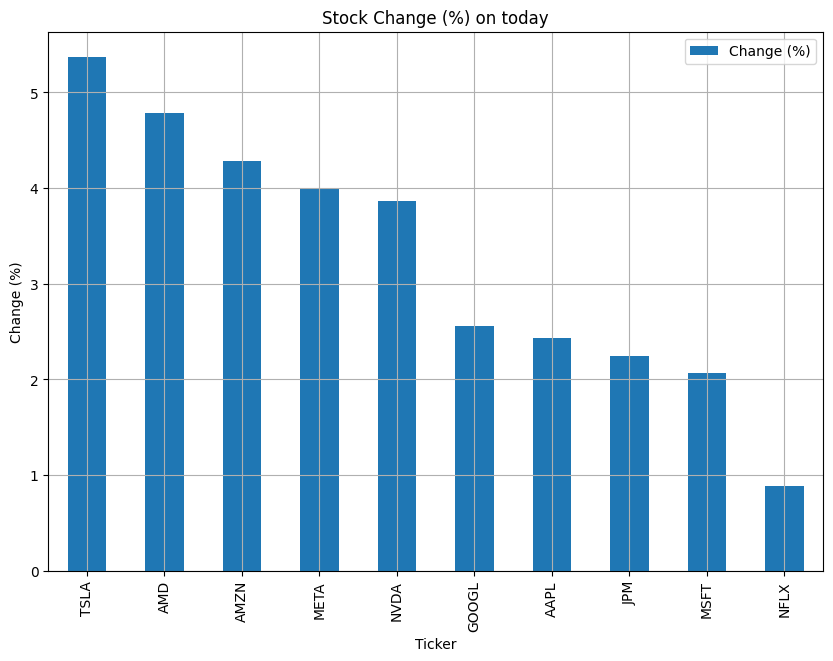

In [ ]:
#ignore 
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
import io
import pandas as pd
import numpy as np
mock_data = {'AAPL': np.float64(2.4331633507028676), 
             'MSFT': np.float64(2.0636844155362275), 
             'GOOGL': np.float64(2.561566548850186), 
             'AMZN': np.float64(4.28456735278061), 
             'TSLA': np.float64(5.366224400956115), 
             'NVDA': np.float64(3.86287766043215), 
             'META': np.float64(3.995766530888617), 
             'JPM': np.float64(2.2454300382664707), 
             'NFLX': np.float64(0.8891324282352583), 
             'AMD': np.float64(4.7878473813337745)}
date_str = "today"
plot_with_pandas(mock_data,date_str)

Defining an autopipline, the core of the automation. We define its source, sink.

In [ ]:

today = datetime.now()

auto_pipeline(
    source=lambda app, pipeline: WebFormSource(app, pipeline, route="/",
    form_intro="""<h1> Select date range and click submit to see a visualization""",
    fields=[
        IntField("Day",default=today.day),
        IntField("Month",default=today.month),
        IntField("Year",default=today.year),
    ]),
    sink=lambda app, pipeline: WebSink(app, pipeline)
)

Pipeline section
----------------

Everything after this is rerun every time an event comes in. At run time, the `event` variable is automatically set with the value of the event that comes from the source.

We can do whatever transformations we please, and then, by setting `event` at the end of the notebook, the value of `event` will automatically be sent to the sink.

Here is a helper function of the output layout.

In [ ]:
def output_layout(parsed_date,top_stock_name,top_stock_change,img_data) -> str:
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Stock Performance</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                text-align: center;
                background-color: #f5f5f5;
                padding: 40px;
            }}
            h1 {{
                color: #333;
                margin-bottom: 20px;
            }}
            img {{
                border: 1px solid #ccc;
                max-width: 90%;
                height: auto;
                box-shadow: 0 0 10px rgba(0,0,0,0.1);
            }}
        </style>
    </head>
    <body>
        <h1>📈 Top Stock on {parsed_date}: {top_stock_name} (change {top_stock_change:.2f}%)</h1>
        <img src="data:image/jpeg;base64,{base64.b64encode(img_data.getvalue()).decode()}" alt="Stock Performance">
    </body>
    </html>
    """
    return html

In this last part we work with the actual event, It initially has the data from the web form and then we use it to calculate the data nad set the result as an HTML containing stylyzed by the output_layout function containing the results from the calculation and image of the result plot.

In [ ]:
form = event["form"]
parsed_date = date(form["Year"], form["Month"], form["Day"]).strftime("%Y-%m-%d")

changes = get_price_changes(STOCKS, parsed_date)

if changes:
    print("No data found. Market may have been closed.")
    top_stock = max(changes, key=changes.get)
    print(f"Most increasing stock on {parsed_date}: {top_stock} ({changes[top_stock]:.2f}%)")
    img_data = plot_with_pandas(changes, parsed_date)


    top_stock_name = top_stock
    top_stock_change = changes[top_stock]

    response = output_layout(parsed_date=parsed_date,top_stock_name=top_stock_name,top_stock_change=top_stock_change,img_data=img_data)




    event["response"] = output_layout(parsed_date=parsed_date,top_stock_name=top_stock_name,top_stock_change=top_stock_change,img_data=img_data)
    event["content_type"] = "text/html"
else:
    print("No data found. Market may have been closed.")

